In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

import preprocessing.VideoFrameDataset as VFD
import model.Encoder as E
import model.Loss as L

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
root = 'data/camera_1_videos'
BATCH_SIZE = 1 #One batch corresponds to 140 frames extracted.
QUEUE_SIZE = 28
EPOCHS = 25
LEARNING_RATE = 0.0001
QUEUE_OFFSET = 7
TAU = 0.1

In [3]:
dataset = VFD.VideoFrameDataset(root, 5)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

In [4]:
model = E.ResNet18Encoder()
model = model.to(device)
inst_disc_loss = L.PairwiseInstanceDiscrimination()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
datapoints = np.empty((0, 64))
with torch.no_grad():
    for batch in dataloader:
        video = batch[0]
        for frame in video:
            frame = frame.unsqueeze(dim = 0)
            frame = frame.to(device)
            output = model(frame)
            datapoints = np.vstack([datapoints, output.detach().cpu().numpy()])

In [6]:
tsne_3D = TSNE(n_components=3, perplexity=30)
tsne_results_3D = tsne_3D.fit_transform(datapoints)

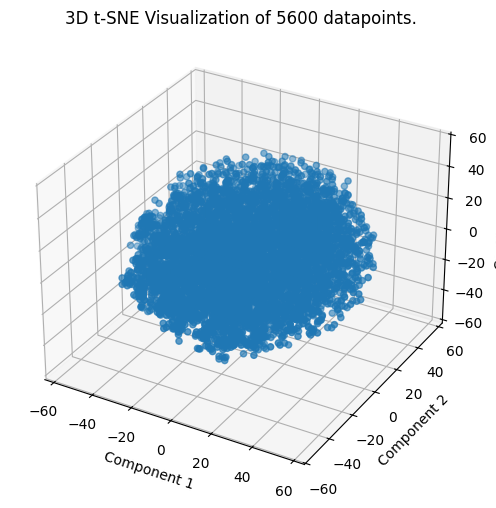

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results_3D[:, 0], tsne_results_3D[:, 1], tsne_results_3D[:, 2])
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("3D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [8]:
tsne_2D = TSNE(n_components=2, perplexity=30)
tsne_results_2D = tsne_2D.fit_transform(datapoints)

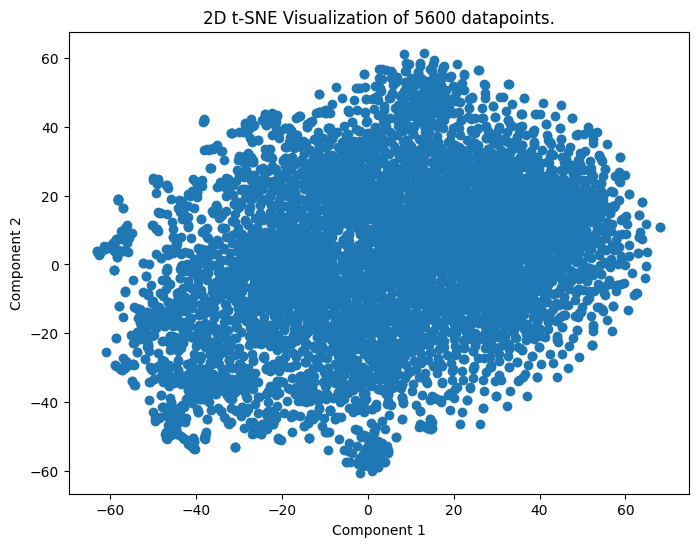

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [10]:
average_loss_list = []
for epoch in range(EPOCHS):

    print("Starting Epoch ", epoch, "...")
    
    batch_num = 0
    batchwise_loss_list = np.ndarray([])
    for batch in dataloader:

        print("Starting Batch ", batch_num, ":")

        queuewise_loss_list = np.ndarray([])
        video = batch[0]
        queue_index = 0
        while(queue_index + QUEUE_SIZE <= len(video)):
            temporal_queue = video[queue_index : queue_index + QUEUE_SIZE].to(device)
            non_temporal_queue = torch.cat([video[0 : queue_index], video[queue_index + QUEUE_SIZE : len(video)]], dim = 0).to(device)
            queue_embeddings = model(temporal_queue)
            outside_embedding = model(non_temporal_queue)
            loss = inst_disc_loss(queue_embeddings, outside_embedding, TAU)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            queuewise_loss_list = np.append(queuewise_loss_list, loss.detach().cpu().numpy())
            queue_index += QUEUE_OFFSET

            if(queue_index%14 == 0):
                print("Processing Queue: ", queue_index, "| Queue Loss = ", loss)
            
        average_loss_val_per_batch = np.mean(queuewise_loss_list)
        batchwise_loss_list = np.append(batchwise_loss_list, average_loss_val_per_batch)

        print("Finished processing batch: ", batch_num, "| Average Batchwise Loss = ", average_loss_val_per_batch)
        print()
        batch_num += 1

    average_loss_list.append(np.mean(batchwise_loss_list))

    print("Finished processing epoch: ", epoch, "| Average Epochwise Loss = ", np.mean(batchwise_loss_list))
    print()
    

Starting Epoch  0 ...
Starting Batch  0 :
Processing Queue:  14 | Queue Loss =  tensor(-1.9999, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  28 | Queue Loss =  tensor(-2.9836, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  42 | Queue Loss =  tensor(-1.1326, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  56 | Queue Loss =  tensor(-2.7351, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  70 | Queue Loss =  tensor(-4.0142, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  84 | Queue Loss =  tensor(-4.7754, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  98 | Queue Loss =  tensor(-4.8325, device='cuda:0', grad_fn=<MulBackward0>)
Processing Queue:  112 | Queue Loss =  tensor(-3.8344, device='cuda:0', grad_fn=<MulBackward0>)
Finished processing batch:  0 | Average Batchwise Loss =  -1.3948985503779516

Starting Batch  1 :
Processing Queue:  14 | Queue Loss =  tensor(-1.9366, device='cuda:0', grad_fn=<MulBackward0>)
Pro

Text(0, 0.5, 'Loss')

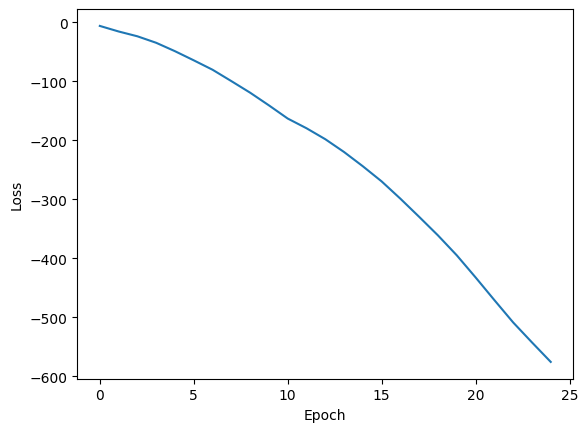

In [18]:
plt.plot(range(len(average_loss_list)), average_loss_list, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [19]:
datapoints = np.empty((0, 64))
with torch.no_grad():
    for batch in dataloader:
        video = batch[0]
        for frame in video:
            frame = frame.unsqueeze(dim = 0)
            frame = frame.to(device)
            output = model(frame)
            datapoints = np.vstack([datapoints, output.detach().cpu().numpy()])

In [20]:
tsne_3D = TSNE(n_components=3, perplexity=30)
tsne_results_3D = tsne_3D.fit_transform(datapoints)

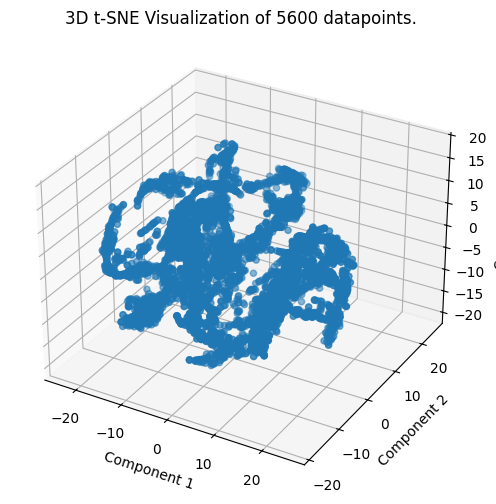

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results_3D[:, 0], tsne_results_3D[:, 1], tsne_results_3D[:, 2])
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("3D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [22]:
tsne_2D = TSNE(n_components=2, perplexity=30)
tsne_results_2D = tsne_2D.fit_transform(datapoints)

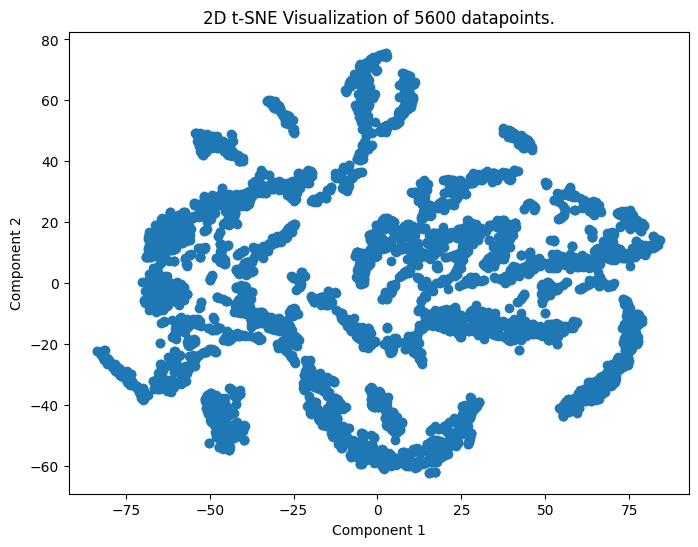

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [24]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, "saved_models/1_28_25_0.0001_7_0.1_ResNet-18.pth")